In [ ]:
# %% libraries

import cdflib

from tqdm import tqdm
from pathlib import Path
import pandas as pd
from numpy import abs, append, arange, insert, linspace, log10, round, zeros
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
from multiprocessing import Pool
from scipy.stats import norm

import dill as pickle

from astropy.time import Time 

import spiceypy as spice
from mpl_toolkits.mplot3d import Axes3D 


from tslearn.piecewise import PiecewiseAggregateApproximation

from astropy.time import Time 

import spiceypy as spice
from mpl_toolkits.mplot3d import Axes3D 


from pyfilterbank import melbank
from scipy import fft

import datetime as dt
import os,sys

_FILE_DIR = os.path.abspath("")
_SRC_DIR = os.path.dirname(_FILE_DIR)
sys.path.append(_SRC_DIR)

# local imports
import tsFB.data.prototyping_metrics as pm
import tsFB.utils.time_chunking as tc
import tsFB.build_filterbanks as fb

# Prepare test data

In [2]:
# %% Get data

year = '2019'
month = '05'
test_cdf_file_path =_SRC_DIR+fb._OMNI_MAG_DATA_DIR+ year +'/omni_hro_1min_'+ year+month+'01_v01.cdf'

mag_df = fb.get_test_data(fname_full_path=test_cdf_file_path)
cols = ['BY_GSE']
mag_df=mag_df[cols]
mag_df

,BY_GSE
2019-05-15 00:00:00,474.4
2019-05-15 00:01:00,475.3
2019-05-15 00:02:00,473.6
2019-05-15 00:03:00,472.6
2019-05-15 00:04:00,470.5
...,...
2019-05-15 23:56:00,419.9
2019-05-15 23:57:00,417.7
2019-05-15 23:58:00,413.2
2019-05-15 23:59:00,411.5


In [3]:
# %% Prepare FT of test data for Fourier applications

cadence = dt.timedelta(seconds=60)

mag_df.sort_index(inplace=True)
mag_df.interpolate(method='index', kind='linear',limit_direction='both',inplace=True)
df_index=pd.date_range(start=mag_df.index[0], end=mag_df.index[-1], freq=cadence)

sig_fft_df = fft.rfftn(mag_df - mag_df.mean(),axes=0)

# Detrending via Convolution in the Time Domain
The Smoothing and Detrending code from "time_chunking.py" (not excutable here)

```python
mag_df=mag_df[cols]
mag_df.sort_index(inplace=True)
preprocessed_mag_df = mag_df.copy()

if detrend_window > timedelta(seconds=0):
    LOG.debug('Detrending')
    smoothed = preprocessed_mag_df.rolling(detrend_window,
        center=True
    ).mean()
    # Subtract the detrend_window (e.g. 30 minutes or 1800s) to detrend
    preprocessed_mag_df = preprocessed_mag_df - smoothed

if smooth_window > timedelta(seconds=0):
    LOG.debug('Smoothing')
    preprocessed_mag_df = preprocessed_mag_df.rolling(smooth_window,
        center=True
    ).mean()
```

In [4]:
window = dt.timedelta(seconds=21000)

In [5]:
# %% Detrending from time_chunking code script

detrend_y = tc.preprocess_smooth_detrend(mag_df=mag_df-mag_df.mean(),
                                        cols=cols,
                                        detrend_window=window,
                                        smooth_window=dt.timedelta(seconds=0))

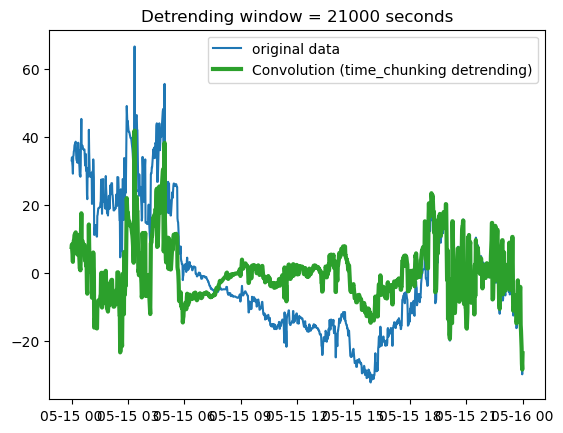

In [6]:
# %% Compare

plt.plot(mag_df.index,mag_df[:]-mag_df.mean(),label='original data')
plt.plot(mag_df.index,detrend_y,color='tab:green',linewidth=3,label='Convolution (time_chunking detrending)')
plt.title(f'Detrending window = {int(window.total_seconds())} seconds')
plt.legend()
plt.show()

# Theoretical Frequency Response

**(Formula from [Ch. 15 of *Digital Signal Processing Textbook*](https://www.dspguide.com/CH15.PDF)**)

Frequency response of an $M$ point moving average filter. The frequency, $f$, runs between $0$ and $0.5$. For $f = 0$, use $H[f] = 1$

$$H[f] = \frac{\sin(\pi f M)}{M\sin(\pi f)}$$

In [7]:
# %% Ch. 15 Formula
def moving_avg_freq_response(f,window=dt.timedelta(minutes=3000),cadence=dt.timedelta(minutes=1)):
    n = int(window.total_seconds()/cadence.total_seconds())
    numerator = np.sin(np.pi*f*n)
    denominator = n*np.sin(np.pi*f)
    return abs(numerator/denominator)

## Detrending in the frequency domain

Since detrending in the time domain is `detrended_sig = signal - mvg_avg(window)`, the *frequency response* of detrending ($DT$) should be

\begin{equation}
DT[f] = 1 - H[f] = 1 - \frac{\sin(\pi f M)}{M \sin(\pi f)}
\end{equation}

In [8]:
# Build theoretical frequency response 
data_len = mag_df.shape[0]  
freq_spectrum = np.linspace(0.0001,data_len/2,(data_len//2)+1)
FR_theory = moving_avg_freq_response(f=freq_spectrum,
                                        window=window,
                                        cadence=cadence)
FR_theory = 1 - FR_theory

Text(0.5, 1.0, 'Zoomed in')

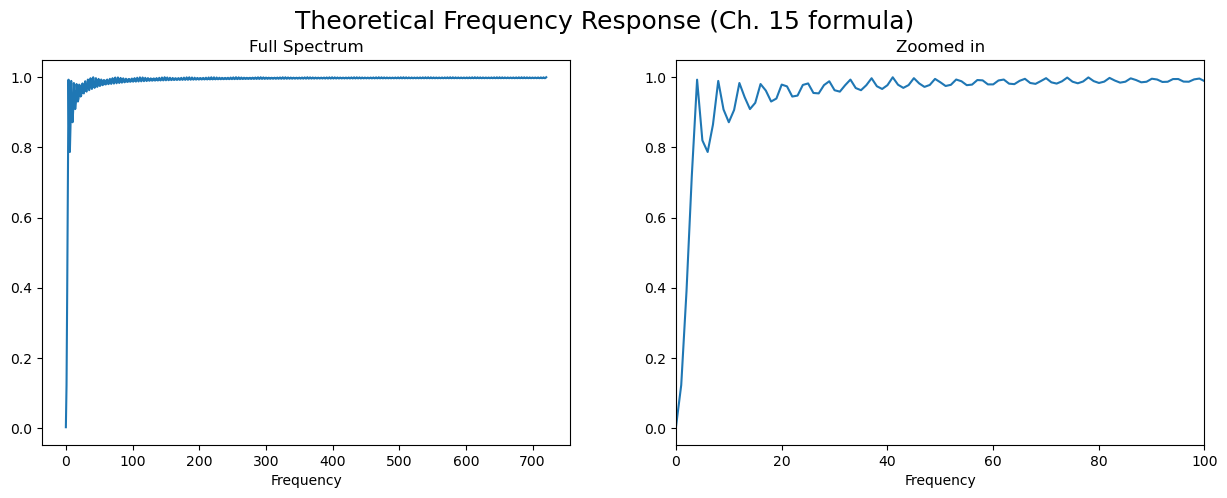

In [9]:
# plot frequency response
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
fig.suptitle("Theoretical Frequency Response (Ch. 15 formula)",fontsize=18)
axes[0].plot(freq_spectrum,FR_theory)
axes[0].set_xlabel("Frequency")
axes[0].set_title('Full Spectrum')
axes[1].plot(freq_spectrum,FR_theory)
axes[1].set_xlim(0,100)
axes[1].set_xlabel("Frequency")
axes[1].set_title('Zoomed in')

In [10]:
# Apply filter: theoretical frequency response
Y = sig_fft_df.ravel()*FR_theory
filtered_y = np.real(fft.irfft(Y))

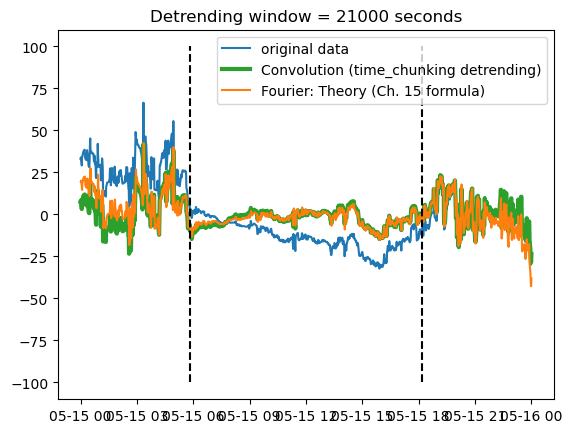

In [11]:
# Compare
plt.plot(mag_df.index,mag_df[:]-mag_df.mean(),label='original data')
plt.plot(mag_df.index,detrend_y,color='tab:green',linewidth=3,label='Convolution (time_chunking detrending)')
plt.plot(mag_df.index[1:],filtered_y,color='tab:orange',label='Fourier: Theory (Ch. 15 formula)')
plt.vlines(min(mag_df.index)+window,-100,100,linestyles='dashed',color='black')
plt.vlines(max(mag_df.index)-window,-100,100,linestyles='dashed',color='black')
plt.title(f'Detrending window = {int(window.total_seconds())} seconds')
plt.legend()
plt.show()

# Empirical application of moving avg. filter
Manually build the rectangular moving average filter and take the FFT.


In [12]:
# useful numbers
data_len = mag_df.shape[0]                              # length of data (i.e. number of samples)
sample_numbers = np.linspace(0,data_len,data_len)       # array of sample numbers
n = int(window.total_seconds()/cadence.total_seconds()) # number of "sample points" in the window (w.r.t. cadence)

length of filter matches data length: True
sum of ones (should equal 350): 350.0


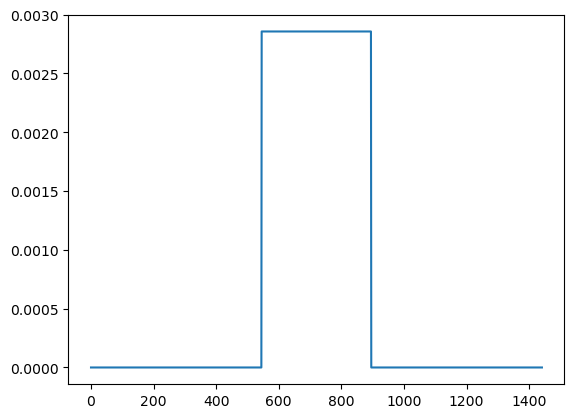

In [13]:
# Make the box
box_filter = np.zeros(data_len) # start with array of zeros of size data_len
print("length of filter matches data length:",len(box_filter)==data_len)

dx = (data_len-n)//2            # the number of zeros to center the box

box_filter[dx:dx+n] = 1         # set values to one
print(f'sum of ones (should equal {n}): {sum(box_filter)}')

# Normalize the box
box_filter = box_filter/np.sum(box_filter)

# visualize
plt.plot(sample_numbers,box_filter)

In [14]:
# FFT of the box filter
FR_empirical = fft.rfft(box_filter)
FR_empirical = 1 - abs(FR_empirical)
#print(FR_empirical.shape)

Text(0.5, 0.98, 'Empirical Frequency Response (FFT of box filter)')

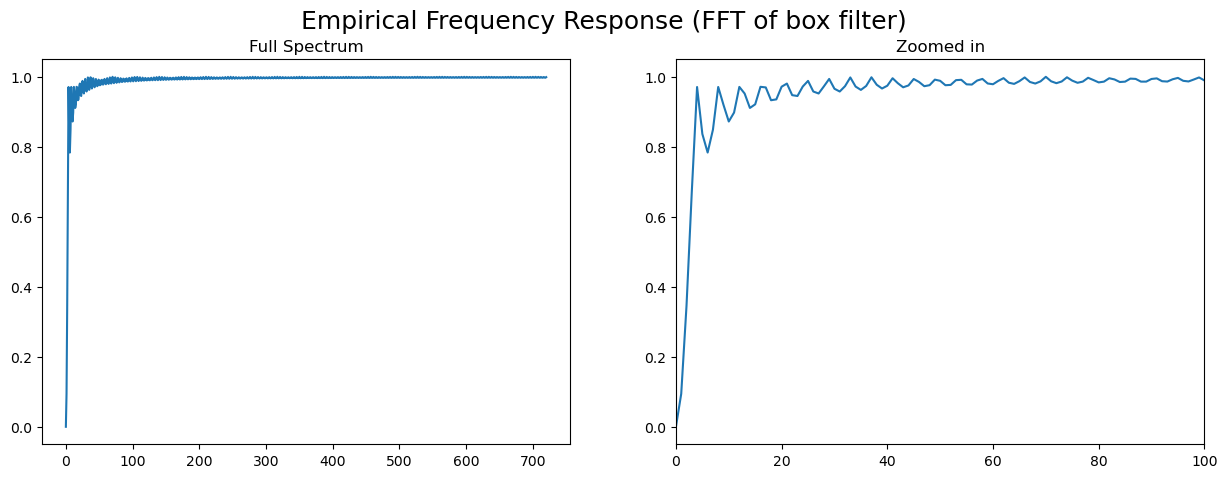

In [15]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
axes[0].plot(np.abs(FR_empirical))
axes[0].set_title('Full Spectrum')
axes[1].plot(np.abs(FR_empirical))
axes[1].set_xlim(0,100)
axes[1].set_title('Zoomed in')
fig.suptitle('Empirical Frequency Response (FFT of box filter)',fontsize=18)

In [16]:
# Apply empirical filter
Y_box = sig_fft_df.ravel()*abs(FR_empirical)
box_filtered_y = np.real(fft.irfft(Y_box))

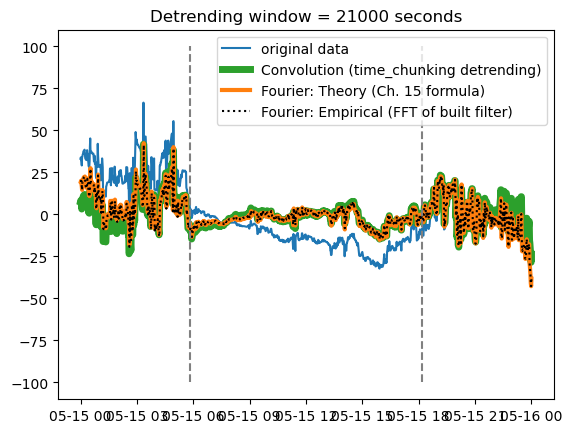

In [17]:
plt.plot(mag_df.index,mag_df[:]-mag_df.mean(),label='original data')
plt.plot(mag_df.index,detrend_y,color='tab:green',linewidth=5,label='Convolution (time_chunking detrending)')
plt.plot(mag_df.index[1:],filtered_y,color='tab:orange',linewidth=3,label='Fourier: Theory (Ch. 15 formula)')
plt.plot(mag_df.index[1:],box_filtered_y,color='black',linestyle='dotted',label='Fourier: Empirical (FFT of built filter)')
plt.vlines(min(mag_df.index)+window,-100,100,linestyles='dashed',color='gray')
plt.vlines(max(mag_df.index)-window,-100,100,linestyles='dashed',color='gray')
plt.title(f'Detrending window = {int(window.total_seconds())} seconds')
plt.legend()
plt.show()